In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from functools import partial

In [ ]:
np.random.seed(42)
tf.compat.v1.set_random_seed(42)

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = '/content/drive/My Drive/Colab Notebooks/plant/dataset/jpeg-224x224/train/'

train_set_raw = tf.keras.preprocessing.image_dataset_from_directory(
              data_dir,
              seed=123,
              image_size=(img_height, img_width),
              batch_size=batch_size
              )

Found 12753 files belonging to 104 classes.


In [ ]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = '/content/drive/My Drive/Colab Notebooks/plant/dataset/jpeg-224x224/val/'

valid_set_pre_split = tf.keras.preprocessing.image_dataset_from_directory(
              data_dir,
              seed=123,
              image_size=(img_height, img_width),
              batch_size=batch_size
              )

Found 3712 files belonging to 104 classes.


In [ ]:
# Create dataset for production

concatenated_set = train_set_raw.concatenate(valid_set_pre_split)

In [ ]:
class_names = valid_set_pre_split.class_names

In [ ]:
# Create validation and test set

test_set_size = int(len(valid_set_pre_split) * .1)

test_set = valid_set_pre_split.take(test_set_size)
valid_set_raw = valid_set_pre_split.skip(test_set_size)

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.mobilenet_v2.preprocess_input(resized_image)
    return final_image, label

In [ ]:
# Data augmentation

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.mobilenet_v2.preprocess_input(resized_image)
    return final_image, label

In [ ]:
batch_size = 32
n_classes = len(train_set_raw.class_names)

In [ ]:
# Training sets

AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset_size = len(train_set_raw)

train_set = train_set_raw.map(preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(dataset_size).repeat().prefetch(AUTOTUNE)

test_set = test_set.map(preprocess, num_parallel_calls=AUTOTUNE)

valid_set = valid_set_raw.map(preprocess, num_parallel_calls=5).cache().repeat().prefetch(AUTOTUNE)
valid_set_size = len(valid_set_raw)

In [ ]:
# Production sets

AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset_size = len(concatenated_set)

concat_set = concatenated_set.map(preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(dataset_size).repeat().prefetch(AUTOTUNE)

In [ ]:
# Visualize data

class_names = train_set_raw.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set_raw.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_set))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
# Base model

base_model = keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
base_model.summary()

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

In [ ]:
## Train top layers only

for layer in base_model.layers:
    layer.trainable = False

# optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
optimizer = keras.optimizers.Nadam(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(2)])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.75 * dataset_size / batch_size),
                    epochs=15)

Epoch 1/15
9/9 [==============================] - 20s 2s/step - loss: 1.3593 - accuracy: 0.6910 - sparse_top_k_categorical_accuracy: 0.8090 - val_loss: 1.8592 - val_accuracy: 0.6597 - val_sparse_top_k_categorical_accuracy: 0.7639
Epoch 2/15
9/9 [==============================] - 19s 2s/step - loss: 1.4289 - accuracy: 0.7326 - sparse_top_k_categorical_accuracy: 0.8472 - val_loss: 2.3690 - val_accuracy: 0.6250 - val_sparse_top_k_categorical_accuracy: 0.7465
Epoch 3/15
9/9 [==============================] - 19s 2s/step - loss: 0.9354 - accuracy: 0.7882 - sparse_top_k_categorical_accuracy: 0.8993 - val_loss: 2.1322 - val_accuracy: 0.6736 - val_sparse_top_k_categorical_accuracy: 0.7639
Epoch 4/15
9/9 [==============================] - 19s 2s/step - loss: 1.5190 - accuracy: 0.7049 - sparse_top_k_categorical_accuracy: 0.8160 - val_loss: 2.1668 - val_accuracy: 0.6181 - val_sparse_top_k_categorical_accuracy: 0.7500
Epoch 5/15
9/9 [==============================] - 19s 2s/step - loss: 1.3707 - a

In [ ]:
## Train top layers only // production

for layer in base_model.layers:
    layer.trainable = False

# optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
optimizer = keras.optimizers.Nadam(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(2)])
history = model.fit(concat_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)],
                    epochs=100)


# loss: 0.8938 - accuracy: 0.7917 - sparse_top_k_categorical_accuracy: 0.8880

Epoch 1/100
12/12 [==============================] - 12s 988ms/step - loss: 5.9121 - accuracy: 0.1224 - sparse_top_k_categorical_accuracy: 0.1589
Epoch 2/100
12/12 [==============================] - 12s 988ms/step - loss: 4.8846 - accuracy: 0.2005 - sparse_top_k_categorical_accuracy: 0.3255
Epoch 3/100
12/12 [==============================] - 12s 991ms/step - loss: 4.6826 - accuracy: 0.3021 - sparse_top_k_categorical_accuracy: 0.4349
Epoch 4/100
12/12 [==============================] - 12s 986ms/step - loss: 4.4451 - accuracy: 0.2786 - sparse_top_k_categorical_accuracy: 0.4479
Epoch 5/100
12/12 [==============================] - 12s 1s/step - loss: 3.9595 - accuracy: 0.4323 - sparse_top_k_categorical_accuracy: 0.5651
Epoch 6/100
12/12 [==============================] - 12s 1s/step - loss: 3.1222 - accuracy: 0.4583 - sparse_top_k_categorical_accuracy: 0.6276
Epoch 7/100
12/12 [==============================] - 12s 990ms/step - loss: 3.1962 - accuracy: 0.4427 - sparse_top_k_categorical_a

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [ ]:
base_model.trainable = True


# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
#for layer in base_model.layers:
#    layer.trainable = True


#optimizer = keras.optimizers.Adam(learning_rate=0.0001)
optimizer = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(2)])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.75 * dataset_size / batch_size),
                    epochs=20)


Epoch 1/20
9/9 [==============================] - 19s 2s/step - loss: 0.2230 - accuracy: 0.9306 - sparse_top_k_categorical_accuracy: 0.9688 - val_loss: 1.4090 - val_accuracy: 0.7326 - val_sparse_top_k_categorical_accuracy: 0.8507
Epoch 2/20
9/9 [==============================] - 18s 2s/step - loss: 0.1651 - accuracy: 0.9514 - sparse_top_k_categorical_accuracy: 0.9757 - val_loss: 1.4680 - val_accuracy: 0.7326 - val_sparse_top_k_categorical_accuracy: 0.8507
Epoch 3/20
9/9 [==============================] - 18s 2s/step - loss: 0.2211 - accuracy: 0.9340 - sparse_top_k_categorical_accuracy: 0.9792 - val_loss: 1.4793 - val_accuracy: 0.7118 - val_sparse_top_k_categorical_accuracy: 0.8403
Epoch 4/20
9/9 [==============================] - 18s 2s/step - loss: 0.2366 - accuracy: 0.9444 - sparse_top_k_categorical_accuracy: 0.9722 - val_loss: 1.5854 - val_accuracy: 0.7396 - val_sparse_top_k_categorical_accuracy: 0.8542
Epoch 5/20
9/9 [==============================] - 18s 2s/step - loss: 0.3943 - a

In [ ]:
# Production top100 layer training

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(2)])
history = model.fit(concat_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    epochs=42)


Epoch 1/42
12/12 [==============================] - 24s 2s/step - loss: 3.9288 - accuracy: 0.4323 - sparse_top_k_categorical_accuracy: 0.5807
Epoch 2/42
12/12 [==============================] - 24s 2s/step - loss: 2.3295 - accuracy: 0.5911 - sparse_top_k_categorical_accuracy: 0.6953
Epoch 3/42
12/12 [==============================] - 24s 2s/step - loss: 1.4282 - accuracy: 0.6536 - sparse_top_k_categorical_accuracy: 0.8021
Epoch 4/42
12/12 [==============================] - 23s 2s/step - loss: 1.1958 - accuracy: 0.6901 - sparse_top_k_categorical_accuracy: 0.8099
Epoch 5/42
12/12 [==============================] - 23s 2s/step - loss: 1.0996 - accuracy: 0.7135 - sparse_top_k_categorical_accuracy: 0.8177
Epoch 6/42
12/12 [==============================] - 23s 2s/step - loss: 1.4559 - accuracy: 0.6589 - sparse_top_k_categorical_accuracy: 0.7656
Epoch 7/42
12/12 [==============================] - 24s 2s/step - loss: 1.1042 - accuracy: 0.7318 - sparse_top_k_categorical_accuracy: 0.8411
Epoch 

In [ ]:
model.evaluate(concat_set, steps=1)

# loss: 1.0796 - accuracy: 0.8125 - sparse_top_k_categorical_accuracy: 0.8807


In [ ]:
# Save model
model.save('/content/drive/My Drive/Colab Notebooks/plant/prod_pre_fine_tuning')

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/plant/pogmodel')
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(2)])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(4)])

In [ ]:
# Check loaded model's architecture
model.summary()

In [ ]:
# Test

model.evaluate(test_set)

11/11 [==============================] - 14s 1s/step - loss: 1.2337 - accuracy: 0.7926 - sparse_top_k_categorical_accuracy: 0.9290


[1.2337449789047241, 0.7926136255264282, 0.9289772510528564]

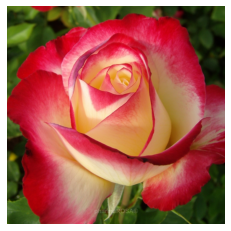

In [ ]:
# Load in the image to be predicted

#rose.png
#sunflower.jpg
tf_img = tf.keras.preprocessing.image.load_img('/content/drive/My Drive/Colab Notebooks/plant/dataset/jpeg-224x224/test/rose.png')
tf_img_tensor = tf.keras.preprocessing.image.img_to_array(tf_img)


# Plot image 
def plot_image(image_to_plot):
    plt.imshow(image_to_plot)
    plt.axis("off")

plot_image(tf_img)

# Preprocess

img_preprocessed = preprocess(tf_img_tensor, None)[0]

# Extend dimension for compatibility with model
img_preprocessed = img_preprocessed[None, :]

In [ ]:
# Predict class of image

img_predictions = model.predict(img_preprocessed)[0]
#predicted_class = np.argmax(img_predictions, axis=1)
k = 3
top_k_classes = img_predictions.argsort()[-k:][::-1]

for index in top_k_classes:
  print('Class:', class_names[index], '- Class index:', index, '- Prediction value:', img_predictions[index])

Class: rose - Class index: 78 - Prediction value: 0.98891044
Class: sword lily - Class index: 89 - Prediction value: 0.009787426
Class: camellia - Class index: 17 - Prediction value: 0.00090770406
